-*- coding: utf-8 -*-

Created on Tue Feb 14 14:19:29 2023

@author: Gisel Guzman-Echavarria

<font color=#08b5ff>Haley's notes added in blue or preceded by `#----- HS:`. Changes made throughout to improve readability (e.g. spacing, comments, fixing typos).</font>

Estimation of the WBT matriz given a range of temperature and humidity (in RH and q)

<font color=#08b5ff>It seems there's a third option -- this notebook computes a matrix of WBTs for various combinations of temperature and humidity measured as relative humidity, specific humidity, and water vapor pressure. The process is pretty much identical for all three methods. We're just using built-in MetPy functions.</font>

In [1]:
import numpy as np
import pandas as pd
from metpy.units import units
import metpy.calc as mpcalc
import xarray as xr
import dask 

In [2]:
# workdir = 'D:/Dropbox (ASU)/Gisel PhD/Survivability Paper Development/Model/'
# workdir = 'C:/Users/gguzma20/Dropbox (ASU)/Gisel PhD/Survivability Paper Development/Model/'

#----- HS: added new directory, mine own
workdir = 'C:/Users/Haley/OneDrive/Graduate/Research/epi_physo/PyHHB/PyHHB/'

### WBT matriz with Specific humidity in the Y-axis

In [2]:
#----- HS: create a range of temperatures (C) to use in the matrix
temperature = np.arange(25, 60, 0.1)

#----- HS: create a range of specific humidities to use in the matrix
q =  np.arange(0, 40.2, 0.2) #g/kg

In [6]:
ds_t= xr.open_dataset(r"C:\Users\cathe\Downloads\tas_full_FGOALS-g3_ssp370_6hr.nc")
temperature = ds_t['tas']

In [3]:
#----- HS: create a meshgrid of temperatures and specific humidities
xx_temp, yy_q = np.meshgrid(temperature, q)

In [ ]:
#----- HS: create a matrix of sea level pressures that is the same shape as xx_temp and yy_q. Assume a standard 
#----- atmospheric pressure everywhere. It might be worth it to replace this 1013 with 1013.25, but that really 
#----- won't change all too much.
atm_sl_p = np.ones(xx_temp.shape)*1013

#----- HS: use a built-in metpy function to calculate relative humidity from specific humdity. we need to do this
#----- to calculate dewpoint, which we ultimately need to calculate wet bulb temperature, since that's the only
#----- measure of humidity that the built-in metpy WBT function will take. Within this function, we're assigning
#----- units of hPa to pressure and C to temperature, dividing specific humidities to get them into g/kg, and
#----- multiplying the whole thing by 100 to put the relative humidity values into percentages.
rh = mpcalc.relative_humidity_from_specific_humidity(atm_sl_p * units.hPa, xx_temp * units.degC, yy_q / 1000) * 100

In [ ]:
rh

In [4]:
#----- HS: use a built-in metpy function to calculate dewpoint from relative humidity, assigning units of C to
#----- temperature and dividing relative humidity by 100 to get it back into decimal format
dew_point = mpcalc.dewpoint_from_relative_humidity(xx_temp * units.degC, rh / 100)

#----- HS: use a built-in metpy function to calculate WBT from pressure, temperature, and dewpoint, assigning units
#----- of hPa to pressure and C to temperature.
WBT_mesh_q = mpcalc.wet_bulb_temperature(atm_sl_p * units.hPa, xx_temp * units.degC, dew_point)

C:\Users\cathe\anaconda3\lib\site-packages\metpy\calc\thermo.py:1022: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
C:\Users\cathe\anaconda3\lib\site-packages\pint\numpy_func.py:303: RuntimeWarning: divide by zero encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
C:\Users\cathe\anaconda3\lib\site-packages\pint\quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


KeyboardInterrupt: 

In [7]:
#----- HS: create the outline of a Pandas DataFrame, where the index is values of specific humidity and each column
#----- is a different temperature
pdWBT_q = pd.DataFrame(index = q, columns = temperature)

#----- HS: Fill the DataFrame with the values of WBT we calculated
pdWBT_q[:] = WBT_mesh_q

#----- HS: Save the DataFrame as a .csv, keeping the column and row labels.
# pdWBT_q.to_csv(workdir + 'codes/qversion_WBT_matrix.csv', header = True, index = True)

### WBT matriz with Water vapor in the Y-axis

In [8]:
#----- HS: create a range of temperatures (C) to use in the matrix
temperature = np.arange(25, 60, 0.1)

#----- HS: create a range of water vapor pressures to use in the matrix
wv =  np.arange(0, 42.25, 0.25) #mmHg

In [9]:
#----- HS: create a meshgrid of temperatures and water vapor pressures
xx_temp, yy_wv = np.meshgrid(temperature, wv)

#----- HS: This line was commented out in the original code, so I'm going to keep it that way for now. It looks 
#----- like Gisel tried to assign units to yy_wv here but decided to do it later instead.
#(yy_wv*units.mmHg).to('kPa')

In [10]:
#----- HS: create a matrix of sea level pressures that is the same shape as xx_temp and yy_q. Assume a standard 
#----- atmospheric pressure everywhere. It might be worth it to replace this 1013 with 1013.25, but that really 
#----- won't change all too much.
atm_sl_p = np.ones(xx_temp.shape)*1013

#----- HS: use a built-in metpy function to calculate dewpoint from water vapor pressure, assigning units of mmHg
#----- to water vapor pressure
dew_point = mpcalc.dewpoint(yy_wv * units.mmHg)

#----- HS: use a built-in metpy function to calculate WBT from pressure, temperature, and dewpoint, assigning units
#----- of hPa to pressure and C to temperature.
WBT_mesh_wv = mpcalc.wet_bulb_temperature(atm_sl_p * units.hPa, xx_temp * units.degC, dew_point)

C:\Users\haley\AppData\Roaming\Python\Python39\site-packages\metpy\calc\thermo.py:1114: RuntimeWarning: divide by zero encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)
C:\Users\haley\AppData\Roaming\Python\Python39\site-packages\metpy\calc\thermo.py:1115: RuntimeWarning: invalid value encountered in divide
  return mpconsts.nounit.zero_degc + 243.5 * val / (17.67 - val)


In [11]:
#----- HS: create the outline of a Pandas DataFrame, where the index is values of water vapor pressure and each
#----- column is a different temperature
pdWBT_wv = pd.DataFrame(index = wv, columns = temperature)

#----- HS: Fill the DataFrame with the values of WBT we calculated
pdWBT_wv[:] = WBT_mesh_wv

#----- HS: Save the DataFrame as a .csv, keeping the column and row labels.
# pdWBT_wv.to_csv(workdir+'codes/wvversion_WBT_matrix.csv', header = True, index = True)

### WBT matriz with Relative humidity in the Y-axis

In [35]:
#----- HS: create a range of temperatures (C) to use in the matrix
temperature = np.arange(-50, 70, .1)

#----- HS: create a range of relative humidities (percentages) to use in the matrix
humidity =  np.arange(0.5, 100.5, 0.5)

#----- HS: create a meshgrid of temperatures and relative humidities
xx_temp, yy_rh = np.meshgrid(temperature, humidity)

#----- HS: use a built-in metpy function to calculate dewpoint from temperature and relative humidity, assigning 
#----- units of C to temperature and dividing relative humidity by 100 to get it back into decimal format
dew_point = mpcalc.dewpoint_from_relative_humidity(xx_temp*units.degC, yy_rh/100)

#----- HS: create a matrix of sea level pressures that is the same shape as xx_temp and yy_q. Assume a standard 
#----- atmospheric pressure everywhere. It might be worth it to replace this 1013 with 1013.25, but that really 
#----- won't change all too much.
atm_sl_p = np.ones(xx_temp.shape) * 1013

#----- HS: use a built-in metpy function to calculate WBT from pressure, temperature, and dewpoint, assigning units
#----- of hPa to pressure and C to temperature.
WBT_mesh = mpcalc.wet_bulb_temperature(atm_sl_p * units.hPa, xx_temp * units.degC, dew_point)

In [50]:
#----- HS: create the outline of a Pandas DataFrame, where the index is values of relative humidities and each
#----- column is a different temperature
og_pdWBT = pd.DataFrame(index = humidity, columns = temperature)

#----- HS: Fill the DataFrame with the values of WBT we calculated
og_pdWBT[:] = WBT_mesh

#----- HS: Save the DataFrame as a .csv, keeping the column and row labels.
# pdWBT.to_csv(workdir+'codes/rhversionWBT_matrix.csv',header=True,index = True)

### NEW AND IMPROVED WBT!

### All code below here added by haley staudmyer

In [1]:
# Calculate wet-bulb temperature, equivalent temperature, and equivalent
# potential temperature from temperature, pressure, and specific humidity.
#
# METHODOLOGY:
#
# Calculates wet-bulb temperature and associated quantities using the Davies-Jones 2008 method.
# Briefly, this involves first calculating the lifting condensation temperature (Bolton 1980 eqn 22),
# then the moist potential temp (Bolton 1980 eqn 24), then
# the Equivalent Potential Temperature (Bolton 1980 eqn 39).
# and finally the wet-bulb temperature (Davies-Jones
# 2008 eqn 3.5-3.8).  An accurate 'first guess' of wet-bulb temperature
# is determined (Davies-Jones 2008 eqn 4.8-4.11), and then iterations via the Newton-Raphson
# method are used to determine the final wet-bulb temperature
# (Davies-Jones 2008 eqn 2.6).
#
# Reference:  Bolton: The computation of equivalent potential temperature.
# 	      Monthly weather review (1980) vol. 108 (7) pp. 1046-1053
#	      Davies-Jones: An efficient and accurate method for computing the
#	      wet-bulb temperature along pseudoadiabats. Monthly Weather Review
#	      (2008) vol. 136 (7) pp. 2764-2785
# 	      Flatau et al: Polynomial fits to saturation vapor pressure.
#	      Journal of Applied Meteorology (1992) vol. 31 pp. 1507-1513

#
# Ported from HumanIndexMod 04-08-16 by Jonathan R Buzan
#
# Ported to Python by Xianxiang Li
# February 2, 2019
#
# Optimizations with numba and bug correction in derivative calculation for Newton's
# Method applied by Alex Goodman
# March 19, 2023


#When called: use temperature in C, pressure in Pa, humidity in kg/kg
#HumidityMode=0 -- specific humidity
#HumidityMode=1 -- relative humidity (%)

#Example: WetBulb(30,10**5,0.02,0)[0]
#should give the result of 26.04 C

import sys
import numba as nb
import numpy as np

#Necessary constants
lambd_a = 3.504    	# Inverse of Heat Capacity
alpha = 17.67 	    # Constant to calculate vapor pressure
beta = 243.5		# Constant to calculate vapor pressure
epsilon = 0.6220	# Conversion between pressure/mixing ratio
es_C = 611.2		# Vapor Pressure at Freezing STD (Pa)
y0 = 3036		    # constant
y1 = 1.78		    # constant
y2 = 0.448		    # constant
Cf = 273.15	# Freezing Temp (K)
p0 = 100000	    # Reference Pressure (Pa)
constA = 2675 	 # Constant used for extreme cold temperatures (K)
vkp = 0.2854	 # Heat Capacity

In [2]:
#@nb.njit(fastmath=True)
def QSat_2(T_k, p_t, p0ndplam):
    #Inputs: T_k is temperature in K; p_t is surface atmos pressure in Pa
    #Outputs: es -- vapor pressure in Pa; rs -- specific humidity in kg/kg

    tcfbdiff = T_k - Cf + beta
    es = es_C * np.exp(alpha*(T_k - Cf)/(tcfbdiff))
    dlnes_dT = alpha * beta/((tcfbdiff)*(tcfbdiff))
    pminuse = p_t - es
    de_dT = es * dlnes_dT

    rs = epsilon * es/(p0ndplam - es + np.spacing(1)) #eps

    # avoid bad numbers
    if rs > 1 or rs < 0:
        rs = np.nan

    return es,rs,dlnes_dT

In [3]:
#@nb.njit(fastmath=True)
def WetBulb(TemperatureC,Pressure,Humidity,HumidityMode):
    #Inputs: temperature in C, pressure in Pa, specific humidity in kg/kg, HumidityMode=0 for specific humidity
    #Outputs: Twb, Teq, epott
    #Twb is in C, others are in K
    TemperatureK = TemperatureC + 273.15
    pnd = (Pressure/p0)**(vkp)
    p0ndplam = p0*pnd**lambd_a
    
    C = 273.15;# Freezing Temperature in K
    T1 = TemperatureK; # Use holder for T

    es, rs, _ = QSat_2(TemperatureK, Pressure, p0ndplam) # first two returned values

    if HumidityMode==0:
        qin = Humidity                   # specific humidity
        relhum = 100.0 * qin/rs          # relative humidity (%)
        vape = es * relhum * 0.01   # vapor pressure (Pa)
    elif HumidityMode==1:
        relhum = Humidity                # relative humidity (%)
        qin = rs * relhum * 0.01         # specific humidity
        vape = es * relhum * 0.01   # vapor pressure (Pa)

    mixr = qin * 1000;          # change specific humidity to mixing ratio (g/kg)


    # Calculate Equivalent Pot. Temp (Pressure, T, mixing ratio (g/kg), pott, epott)
    # Calculate Parameters for Wet Bulb Temp (epott, Pressure)
    D = 1.0/(0.1859*Pressure/p0 + 0.6512)
    k1 = -38.5*pnd*pnd + 137.81*pnd - 53.737
    k2 = -4.392*pnd*pnd + 56.831*pnd - 0.384

    # Calculate lifting condensation level
    tl = (1.0/((1.0/((T1 - 55))) - (np.log(relhum/100.0)/2840.0))) + 55.0

    # Theta_DL: Bolton 1980 Eqn 24.
    theta_dl = T1*((p0/(Pressure-vape))**vkp) * ((T1/tl)**(mixr*0.00028))
    # EPT: Bolton 1980 Eqn 39.
    epott = theta_dl * np.exp(((3.036/tl)-0.00178)*mixr*(1 + 0.000448*mixr))
    Teq = epott*pnd	# Equivalent Temperature at pressure
    X = (C/Teq)**3.504

    # Calculates the regime requirements of wet bulb equations.
    invalid = Teq > 600 or Teq < 200
    hot = Teq > 355.15
    cold = X>=1 and X<=D
    if invalid:
        return np.nan, np.nan, epott

    # Calculate Wet Bulb Temperature, initial guess
    # Extremely cold regime if X.gt.D then need to calculate dlnesTeqdTeq
    es_teq, rs_teq, dlnes_dTeq = QSat_2(Teq, Pressure, p0ndplam)
    if X<=D:
        wb_temp = C + (k1 - 1.21 * cold - 1.45 * hot - (k2 - 1.21 * cold) * X + (0.58 / X) * hot)
    else:
        wb_temp = Teq - ((constA*rs_teq)/(1 + (constA*rs_teq*dlnes_dTeq)))

    # Newton-Raphson Method
    maxiter = 2
    iter = 0
    delta = 1e6

    while delta>0.01 and iter<maxiter:
        foftk_wb_temp, fdwb_temp = DJ(wb_temp, Pressure, p0ndplam)
        delta = (foftk_wb_temp - X)/fdwb_temp  #float((foftk_wb_temp - X)/fdwb_temp)
        delta = np.minimum(10,delta)
        delta = np.maximum(-10,delta) #max(-10,delta)
        wb_temp = wb_temp - delta
        Twb = wb_temp
        iter = iter+1

    return np.round(Twb-C,2),Teq,epott

In [4]:
#@nb.njit(fastmath=True)
def WetBulb_all(tempC, Pres, relHum, Hum_mode):
    Twb = np.empty_like(tempC)
    Teq = np.empty_like(tempC)
    epott = np.empty_like(tempC)
    for i in nb.prange(Twb.size):
        Twb[i], Teq[i], epott[i] = WetBulb(tempC[i], Pres[i], relHum[i], Hum_mode)

In [5]:
#@nb.njit(fastmath=True, parallel=True)
def WetBulb_par(tempC, Pres, relHum, Hum_mode):
    Twb = np.empty_like(tempC)
    Teq = np.empty_like(tempC)
    epott = np.empty_like(tempC)
    for i in nb.prange(Twb.size):
        Twb[i], Teq[i], epott[i] = WetBulb(tempC[i], Pres[i], relHum[i], Hum_mode)

In [6]:
#@nb.njit(fastmath=True)
def DJ(T_k, p_t, p0ndplam):
    # Constants used to calculate es(T)
    # Clausius-Clapeyron
    tcfbdiff = T_k - Cf + beta
    es = es_C * np.exp(alpha*(T_k - Cf)/(tcfbdiff))
    dlnes_dT = alpha * beta/((tcfbdiff)*(tcfbdiff))
    pminuse = p_t - es
    de_dT = es * dlnes_dT

    # Constants used to calculate rs(T)
    rs = epsilon * es/(p0ndplam - es + np.spacing(1)) #eps)
    prersdt = epsilon * p_t/((pminuse)*(pminuse))
    rsdT = prersdt * de_dT

    # Constants used to calculate g(T)
    rsy2rs2 = rs + y2*rs*rs
    oty2rs = 1 + 2.0*y2*rs
    y0tky1 = y0/T_k - y1
    goftk = y0tky1 * (rs + y2 * rs * rs)
    gdT = - y0 * (rsy2rs2)/(T_k*T_k) + (y0tky1)*(oty2rs)*rsdT

    # Calculations used to calculate f(T,ndimpress)
    foftk = ((Cf/T_k)**lambd_a)*(1 - es/p0ndplam)**(vkp*lambd_a)* \
        np.exp(-lambd_a*goftk)
    fdT = -lambd_a*(1.0/T_k + vkp*de_dT/pminuse + gdT) * foftk

    return foftk,fdT

In [7]:
#----- HS: create a range of temperatures (C) to use in the matrix
temperature = np.arange(-50, 70, .1)

#----- HS: create a range of relative humidities (percentages) to use in the matrix
humidity =  np.arange(0, .02, 0.005)

In [8]:
#----- HS: create a meshgrid of temperatures and specific humidities
xx_temp, yy_rh = np.meshgrid(temperature, humidity)

In [9]:
#----- HS: create a matrix of sea level pressures that is the same shape as xx_temp and yy_q. Assume a standard 
#----- atmospheric pressure everywhere. It might be worth it to replace this 1013 with 1013.25, but that really 
#----- won't change all too much.
atm_sl_p = np.ones(xx_temp.shape) * 101300

Twb = np.empty_like(xx_temp)
Teq = np.empty_like(xx_temp)
epott = np.empty_like(xx_temp)

for i in np.arange(0, np.shape(xx_temp)[0], 1):
    for j in np.arange(0, np.shape(xx_temp)[1], 1):
        Twb[i][j], Teq[i][j], epott[i][j] = WetBulb(xx_temp[i][j], atm_sl_p[i][j], yy_rh[i][j], HumidityMode = 0)

C:\Users\haley\AppData\Local\Temp\ipykernel_6084\1944119015.py:34: RuntimeWarning: divide by zero encountered in log
  tl = (1.0/((1.0/((T1 - 55))) - (np.log(relhum/100.0)/2840.0))) + 55.0


In [13]:
#----- HS: create the outline of a Pandas DataFrame, where the index is values of relative humidities and each
#----- column is a different temperature
pdWBT = pd.DataFrame(index = humidity, columns = temperature)

#----- HS: Fill the DataFrame with the values of WBT we calculated
pdWBT[:] = Twb

#----- HS: Save the DataFrame as a .csv, keeping the column and row labels.
# pdWBT.to_csv(workdir + 'codes/rhversionWBT_matrix_DJ.csv', header = True, index = True)

In [14]:
# og_pdWBT = pd.read_csv(workdir + 'codes/rhversion_WBT_matrix.csv', index_col=0, header=0)
# og_pdWBT
pdWBT

,-50.0,-49.9,-49.8,-49.7,-49.6,-49.5,-49.4,-49.3,-49.2,-49.1,...,69.0,69.1,69.2,69.3,69.4,69.5,69.6,69.7,69.8,69.9
0.000,-50.11,-50.01,-49.91,-49.81,-49.71,-49.61,-49.51,-49.41,-49.32,-49.22,...,21.79,21.81,21.84,21.86,21.89,21.91,21.93,21.96,21.98,22.0
0.005,-39.98,-39.87,-39.77,-39.67,-39.57,-39.46,-39.36,-39.26,-39.16,-39.05,...,25.71,25.73,25.76,25.78,25.8,25.82,25.84,25.86,25.88,25.9
0.010,-30.81,-30.71,-30.61,-30.5,-30.4,-30.29,-30.19,-30.09,-29.98,-29.88,...,28.83,28.85,28.87,28.88,28.9,28.92,28.94,28.96,28.98,29.0
0.015,-22.19,-22.08,-21.98,-21.88,-21.78,-21.68,-21.57,-21.47,-21.37,-21.27,...,31.5,31.51,31.53,31.55,31.57,31.58,31.6,31.62,31.63,31.65


In [15]:
test = og_pdWBT - pdWBT
test

NameError: name 'og_pdWBT' is not defined

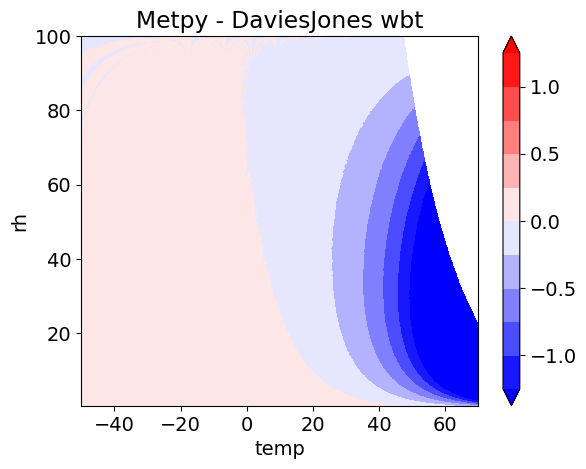

In [112]:
fig, ax = plt.subplots()
orig_cmap = matplotlib.cm.coolwarm
# shiftedColorMap(orig_cmap, midpoint = .75, stop = 1, name = 'shiftedcmap')
CS = ax.contourf(xx_temp, yy_rh, test, levels = np.arange(-1.25,1.5,0.25), extend = 'both', 
                 cmap = 'bwr')
# ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Metpy - DaviesJones wbt')
plt.ylabel("rh")
plt.xlabel("temp")
cbar = fig.colorbar(CS)
# cb_ymin = -1
# cb_ymax = 1
# cb_xmin, cb_xmax = cbar.ax.get_xlim()
# cbar.outline.set_visible(False)  # hide the surrounding spines, which are too large after set_ylim
# cbar.ax.add_patch(plt.Rectangle((cb_xmin, cb_ymin), cb_xmax - cb_xmin, cb_ymax - cb_ymin,
#                                 fc='none', ec='black', clip_on=False))
# cbar.ax.set_ylim(cb_ymin, cb_ymax)